In [1]:
import numpy as np
import pandas as pd
import itertools
from matplotlib import pyplot as plt

**The shared data contains only prepared data: `X_train`, `y_train`, `X_valid`, `y_valid`. To reproduce, execute the commented code below (first, uncomment it of course) and move to RF training (cell 13 or 14).**

In [ ]:
# # how to read data
# import pickle
# with open('../../data/mobile_app_launches_sessions_payments.pkl', 'rb') as f:
#     shared_data = pickle.load(f)
# X_train, y_train = shared_data['X_train'], shared_data['y_train']
# X_valid, y_valid = shared_data['X_valid'], shared_data['y_valid']

In [2]:
df = pd.read_csv('../../data/mobile_app_launches_sessions_payments.csv.gz')

In [3]:
df.shape

(1177829, 49)

In [4]:
df.columns

Index(['idfa', 'idfv', 'gaid', 'android_id', 'imei', 'waid', 'idDevice',
       'idProfile', 'idApp', 'idCountry', 'idRegion', 'age', 'idGender', 'dt',
       'launches1', 'launches2', 'launches3', 'launches4', 'launches5',
       'launches6', 'launches7', 'launches8', 'sessions1', 'sessions2',
       'sessions3', 'sessions4', 'sessions5', 'sessions6', 'sessions7',
       'sessions8', 'num_payments1', 'num_payments2', 'num_payments3',
       'num_payments4', 'num_payments5', 'num_payments6', 'num_payments7',
       'num_payments8', 'sum_payments1', 'sum_payments2', 'sum_payments3',
       'sum_payments4', 'sum_payments5', 'sum_payments6', 'sum_payments7',
       'sum_payments8', 'ltvDay30', 'ltvDay60', 'ltvDay90'],
      dtype='object')

In [5]:
(df['sum_payments8'] > 0).value_counts()

False    1108205
True       69624
Name: sum_payments8, dtype: int64

In [6]:
df.sort_values(by='dt', inplace=True)

In [7]:
y = (df['ltvDay90'] > 0).astype('int')

In [8]:
y.mean()

0.07425356312333964

In [9]:
sessions = ['sessions' + str(i) for i in range(1, 9)]
launches = ['launches' + str(i) for i in range(1, 9)]
num_payments = ['num_payments' + str(i) for i in range(1, 9)]
sum_payments = ['sum_payments' + str(i) for i in range(1, 9)]

In [10]:
X = df[sessions + launches + num_payments + sum_payments]

In [11]:
X.shape, y.shape

((1177829, 32), (1177829,))

In [12]:
train_share = 0.7
train_size = int(train_share * X.shape[0])

X_train, X_valid = X.iloc[:train_size, :], X.iloc[train_size:, :]
y_train, y_valid = y.iloc[:train_size], y.iloc[train_size:]

In [13]:
y_train.mean(), y_valid.mean()

(0.0763147680962546, 0.06944409068654503)

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [15]:
forest = RandomForestClassifier(n_estimators=300, class_weight='balanced',
                                n_jobs=4, random_state=17)

In [16]:
%%time
forest.fit(X_train, y_train)

CPU times: user 11min 15s, sys: 3min 49s, total: 15min 5s
Wall time: 2min 6s


RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=4, oob_score=False, random_state=17,
            verbose=0, warm_start=False)

In [17]:
forest_pred_probs = forest.predict_proba(X_valid)[:, 1]

In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import roc_auc_score

**Is that good?**

In [19]:
roc_auc_score(y_valid, forest_pred_probs)

0.9647325914788966

**Accuracy can be misleading**

*Baseline*

In [20]:
accuracy_score(y_valid, X_valid['sum_payments8'] > 0)

0.9879156301560214

In [21]:
accuracy_score(y_valid, forest_pred_probs > 0.5)

0.9857364814956318

In [22]:
y_valid.shape

(353349,)

In [23]:
pred_df = pd.DataFrame({'true': y_valid, 'pred_forest': forest_pred_probs, 
             'pred_baseline': (X_valid['sum_payments8'] > 0).astype('int')})

In [24]:
pred_df.sort_values(by='pred_forest', ascending=False, inplace=True)
pred_df.head()

,true,pred_forest,pred_baseline
12595,1,1.0,1
76749,1,1.0,1
18479,1,1.0,1
45273,1,1.0,1
43080,1,1.0,1


In [25]:
pred_df.iloc[:50000]['true'].mean() / y_valid.mean()

6.29340805933654

In [26]:
pred_df.sort_values(by='pred_baseline', 
                    ascending=False).iloc[:50000]['true'].mean() / y_valid.mean()

5.8703339041486675

**Precision/recall**

In [27]:
precision_score(y_valid, forest_pred_probs > 0.5), \
    precision_score(y_valid, X_valid['sum_payments8'] > 0),

(0.9615129710282143, 1.0)

In [28]:
recall_score(y_valid, forest_pred_probs > 0.5), \
    recall_score(y_valid, X_valid['sum_payments8'] > 0),

(0.8277365718477464, 0.825984187790366)

In [29]:
from sklearn.metrics import f1_score

In [30]:
f1_score(y_valid, forest_pred_probs > 0.5), \
    f1_score(y_valid, X_valid['sum_payments8'] > 0),

(0.8896237571722657, 0.904700263357586)

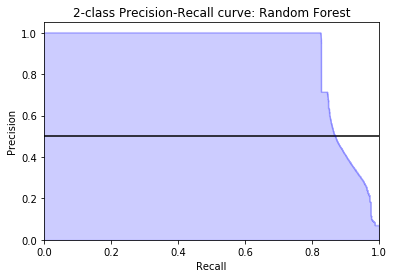

In [31]:
from sklearn.metrics import precision_recall_curve
from sklearn.utils.fixes import signature

precision, recall, thres = precision_recall_curve(y_valid, forest_pred_probs)
    
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.hlines(y=0.5, xmin=0, xmax=1)
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: Random Forest');

In [32]:
tau = 0
precision_score(y_valid, forest_pred_probs > tau), \
recall_score(y_valid, forest_pred_probs > tau)

(0.08408178268498546, 0.9881408427744722)

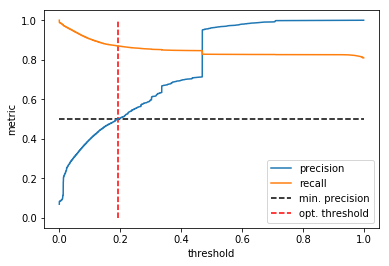

In [33]:
plt.plot(thres, precision[:-1], label='precision')
plt.plot(thres, recall[:-1], label='recall');
plt.hlines(y=0.5, xmin=0, xmax=1, label='min. precision', linestyles='dashed')
plt.vlines(x=0.194, ymin=0, ymax=1, color='red', label='opt. threshold', linestyles='dashed')
plt.legend();
plt.xlabel('threshold')
plt.ylabel('metric');

In [34]:
precision_score(y_valid, forest_pred_probs > 0.194), \
    recall_score(y_valid, forest_pred_probs > 0.194)

(0.501787646422355, 0.8693862580487407)

In [35]:
precision_score(y_valid, X_valid['sum_payments8'] > 0),\
recall_score(y_valid, X_valid['sum_payments8'] > 0),

(1.0, 0.825984187790366)

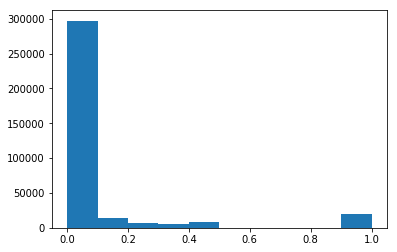

In [36]:
plt.hist(forest_pred_probs);

**Feature importance**

In [37]:
pd.DataFrame(forest.feature_importances_, index=X.columns,
             columns=['importance']).sort_values(by='importance',
                                                ascending=False)

,importance
num_payments8,0.120221
sum_payments8,0.117659
sum_payments7,0.074976
num_payments7,0.072070
num_payments6,0.063004
sum_payments6,0.042955
sessions8,0.040348
launches8,0.039541
sum_payments5,0.036355
num_payments5,0.033727


In [38]:
from sklearn.metrics import confusion_matrix

In [39]:
def plot_confusion_matrix(actual, predicted, classes,
                          normalize=False,
                          title='Confusion matrix', figsize=(7,7),
                          cmap=plt.cm.Blues, path_to_save_fig=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm = confusion_matrix(actual, predicted).T
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Predicted label')
    plt.xlabel('True label')
    
    if path_to_save_fig:
        plt.savefig(path_to_save_fig, dpi=300, bbox_inches='tight')

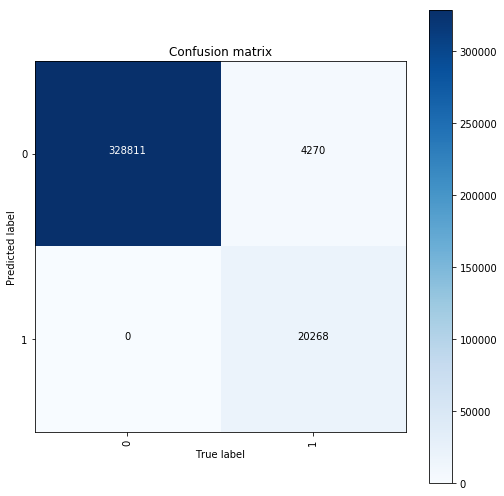

In [40]:
plot_confusion_matrix(actual=y_valid, predicted=X_valid['sum_payments8'] > 0,
                     classes=forest.classes_)

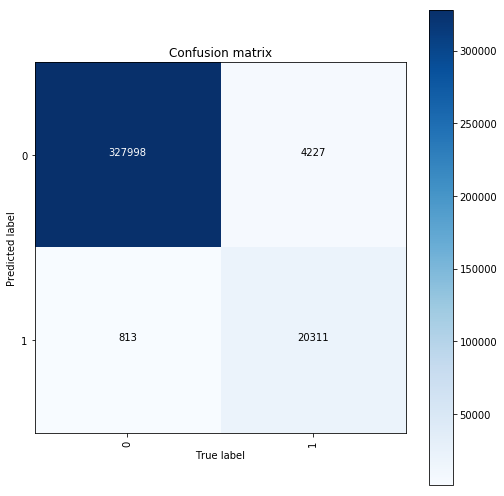

In [41]:
plot_confusion_matrix(actual=y_valid, predicted=(forest_pred_probs > 0.5),
                     classes=forest.classes_)

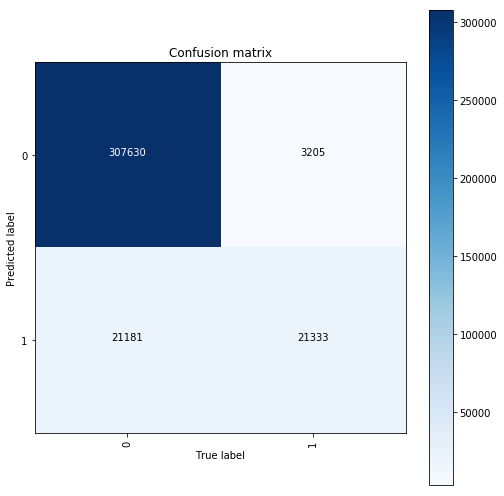

In [42]:
plot_confusion_matrix(actual=y_valid, predicted=(forest_pred_probs > 0.194),
                     classes=forest.classes_)

## Logistic regression

In [43]:
from sklearn.preprocessing import StandardScaler

In [44]:
logit = LogisticRegression(n_jobs=4, random_state=17, 
                           class_weight='balanced', solver='sag')

In [45]:
scaler = StandardScaler()

In [46]:
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

/home/yorko/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/yorko/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/home/yorko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  


In [47]:
%%time
logit.fit(X_train_scaled, y_train)

CPU times: user 1min, sys: 150 ms, total: 1min
Wall time: 57.2 s


/home/yorko/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=4, penalty='l2', random_state=17,
          solver='sag', tol=0.0001, verbose=0, warm_start=False)

In [48]:
logit_pred_probs = logit.predict_proba(X_valid_scaled)[:, 1]

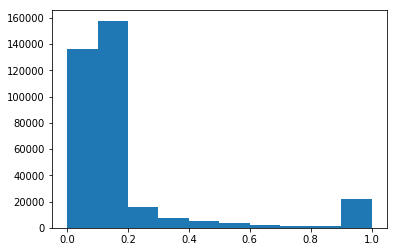

In [49]:
plt.hist(logit_pred_probs);

**Is that good?**

In [50]:
roc_auc_score(y_valid, logit_pred_probs)

0.9764940094392004

**Accuracy can be misleading**

*Baseline*

In [51]:
accuracy_score(y_valid, X_valid['sum_payments8'] > 0)

0.9879156301560214

In [52]:
accuracy_score(y_valid, logit_pred_probs > 0.5)

0.9642449815904389

In [53]:
pred_df = pd.DataFrame({'true': y_valid, 'pred_logit': logit_pred_probs, 
             'pred_baseline': (X_valid['sum_payments8'] > 0).astype('int')})

In [54]:
pred_df.sort_values(by='pred_logit', ascending=False, inplace=True)
pred_df.head()

,true,pred_logit,pred_baseline
62466,1,1.0,1
10587,1,1.0,1
32466,1,1.0,1
52663,1,1.0,1
52996,1,1.0,1


In [55]:
pred_df.iloc[:50000]['true'].mean() / y_valid.mean()

6.4604489102616345

In [56]:
pred_df.sort_values(by='pred_baseline', 
                    ascending=False).iloc[:50000]['true'].mean() / y_valid.mean()

5.840669753036107

**Precision/recall**

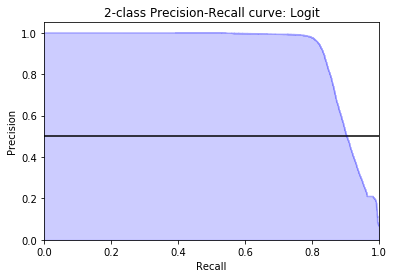

In [57]:
precision, recall, thres = precision_recall_curve(y_valid, logit_pred_probs)
    
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.hlines(y=0.5, xmin=0, xmax=1)
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: Logit');

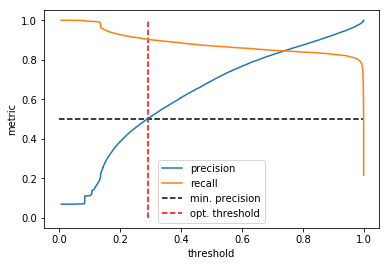

In [58]:
plt.plot(thres, precision[:-1], label='precision')
plt.plot(thres, recall[:-1], label='recall');
plt.hlines(y=0.5, xmin=0, xmax=1, label='min. precision', linestyles='dashed')
plt.vlines(x=0.29, ymin=0, ymax=1, color='red', label='opt. threshold', linestyles='dashed')
plt.legend();
plt.xlabel('threshold')
plt.ylabel('metric');

In [59]:
precision_score(y_valid, logit_pred_probs > 0.29), \
    recall_score(y_valid, logit_pred_probs > 0.29)

(0.5012316662523447, 0.9038633955497596)

In [60]:
precision_score(y_valid, X_valid['sum_payments8'] > 0),\
recall_score(y_valid, X_valid['sum_payments8'] > 0),

(1.0, 0.825984187790366)

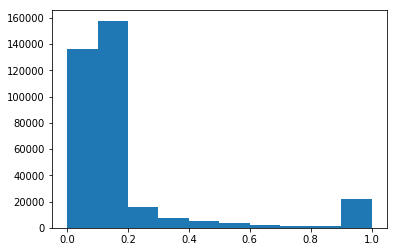

In [61]:
plt.hist(logit_pred_probs);

**Logistic regression worked better for us. Cool! We'll stick to this model. Also, logit will work better in case of sparse features.**

**Now let's take a look at coefficients**

In [62]:
pd.DataFrame(logit.coef_.reshape(-1, 1), index=X.columns,
             columns=['coef']).sort_values(by='coef',
                                                ascending=False)

,coef
num_payments8,3.415361
num_payments7,2.247397
num_payments6,1.757264
sessions8,1.605800
num_payments5,1.471147
sessions1,1.445354
num_payments4,1.290498
num_payments3,1.121328
num_payments2,0.975069
sessions2,0.951102


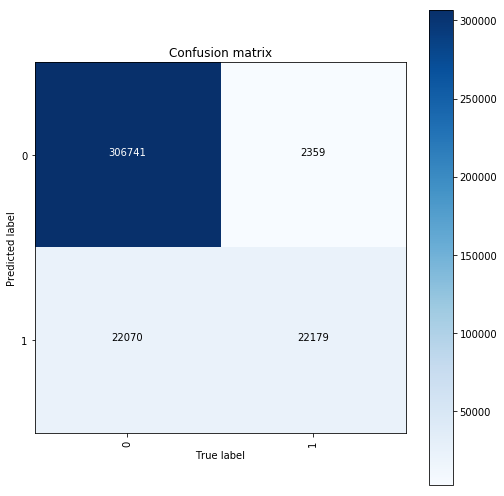

In [63]:
plot_confusion_matrix(actual=y_valid, predicted=(logit_pred_probs > 0.29),
                     classes=logit.classes_)

In [64]:
# import pickle

In [65]:
# data_to_share = {'X_train': X_train,
#                  'y_train': y_train,
#                  'X_valid': X_valid,
#                  'y_valid': y_valid}

In [66]:
# with open('../../data/mobile_app_launches_sessions_payments.pkl', 'wb') as f:
#     pickle.dump(data_to_share, f)